# Optimization

In this demo, we try to visualize some common optimizers from `torch.optim`.

**Disclaimer:** Code largely based from 3springs' `viz_torch_optim` [Github repo](https://github.com/3springs/viz_torch_optim), which in turn is also roughly based from Louis Tiao's [blog](http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/). A lot of the function/class/variable names are edited according to which I think suited them best.

## Function

First, we define the function we wish to optimize. A list of test functions for optimization can be found in [this Wikipedia link](https://en.wikipedia.org/wiki/Test_functions_for_optimization), alongside param bounds and global minima.

In [1]:
class Function:
    def __init__(self, fcn, x0, minima, bounds, lr=1e-3, epoch=2000):
        """
        Inputs:
            fcn    : function(x, y)
            x0     : initial starting point
            minima : list or ndarray of [x,y] that will give the global minima
            bounds : list or ndarray of [x,y] bounds of form [[xmin, xmax],[ymin,ymax]]
            lr     : learning rate
            epoch  : number of optimization steps
        """
        super().__init__()
        
        self.fcn = fcn
        self.x0 = x0
        self.minima = minima
        self.bounds = bounds
        self.lr = lr
        self.epoch = epoch
        
        self.xmin = bounds[0][0]
        self.xmax = bounds[0][1]
        self.ymin = bounds[1][0]
        self.ymax = bounds[1][1]

### Beale's function:

$$
f(x,y) = (1.5-x+xy)^2 + (2.25-x+xy^2)^2 + (2.625-x+xy^3)^2
$$

In [2]:
import numpy as np
import torch
from torch.autograd import Variable

def Tensor(x):
    """
    Since we will be dealing with tensors later, we need this function
    to convert our inputs to tensor.
    
    Input/s:
        x : input of format ndarray, list, or tensor
        
    Output/s:
        y : tensor(x)
    """
    if isinstance(x, np.ndarray):
        return Variable(torch.FloatTensor(x))
    elif isinstance(x, list):
        return Variable(torch.Tensor(x))
    elif isinstance(x, (float, int, np.generic)):
        return Variable(torch.Tensor([float(x)]))
    else:
        return x

def beales(params):
    x, y = params
    x = Tensor(x)
    y = Tensor(y)
    return (1.5-x+x*y)**2 + (2.5-x+x*y**2)**2 + (2.625-x+x*y**3)**2

We define our hyperparameters.

**Note**: Unlike minima and bounds which are given, `x0` can be freely chosen as long as they are within bounds. The value of `x0` can influence the time it takes for our optimizer to converge, if it converges at all.

In [3]:
# Beales' Hyperparameters
x0 = [2., 1.7]
minima = [3., 0.5]
bounds = [[-4.5, 4.5],[-4.5, 4.5]]
lr = 1e-3
num_epochs = 2000
param_step = 0.2

**Note** Do not confuse yourselves with `num_epochs` and `param_steps` above.

 - num_epochs - number of optim steps we will pass to Function()
 - param_steps - determines the interval of our (x,y), which dictates num of data points

In [4]:
beales = Function(fcn=beales, x0=x0, minima=minima, bounds=bounds, lr=lr, epoch=num_epochs)

## 2D Contour

We plot the 2D contour of our function, with $z = f(x,y)$ as contour. But before that, we need to evaluate our function over the (x,y) bounds.

In [5]:
def fcn_over_bounds(fcn, param_step=0.2):
    """
    Calculates the function over the (x,y) bounds.
    
    Input/s:
        fcn : Function()
    Output/s:
        x   : ndarray of x coordinates
        y   : ndarray of y coordinates
        z   : ndarray of f(x,y) coordinates
    """
    x = np.arange(fcn.xmin, fcn.xmax + param_step, param_step)
    y = np.arange(fcn.ymin, fcn.ymax + param_step, param_step)
    
    x, y = np.meshgrid(x, y)
    z = fcn.fcn([x, y]).numpy()  
    
    z += z.min() + 1.1
    return x, y, z

In [6]:
xyz = fcn_over_bounds(beales)

In [7]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_2dcontour(fcn, xyz, show_plot=True):
    """
    Plot 2d Contours
    
    Input/s:
        fcn : Function()
        xyz : (x,y,z) ndarray parameters
    """
    minima = np.array(fcn.minima).reshape(-1, 1)
    x0 = np.array([fcn.x0]).T
    x, y, z = xyz
    
    ax = plt.gca()
    cm = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    plt.colorbar(cm)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    ax.plot(*minima, 'r*', markersize=10)
    ax.plot(*x0, 'r+', markersize=10)
    
    ax.set_xlim((fcn.xmin, fcn.xmax))
    ax.set_ylim((fcn.ymin, fcn.ymax))
    
    if show_plot:
        plt.show()
    
    return ax

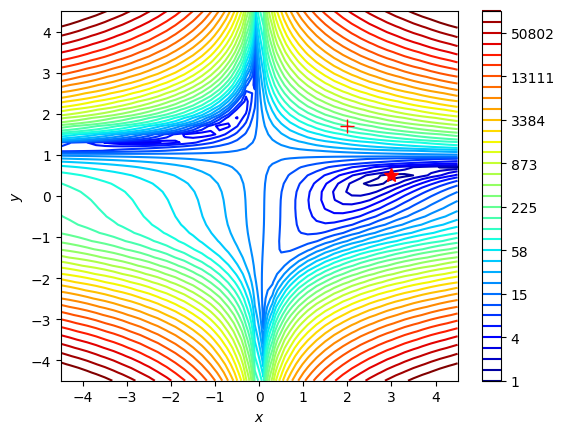

In [8]:
contour2d = plot_2dcontour(beales, xyz)

## Testing Optimizer

With our function set, we now define the optimizers we want to test and visualize. We will use `torch.optim` for this.

In [9]:
import torch.optim as optim

optimizers = dict(SGD = lambda params: optim.SGD(params, lr=beales.lr/10),
                 AdaGrad = lambda params: optim.Adagrad(params, lr=beales.lr*20),
                 AdaDelta = lambda params: optim.Adadelta(params),
                 RMSprop = lambda params: optim.RMSprop(params, lr=beales.lr*10),
                 Adam = lambda params: optim.Adam(params, lr=beales.lr*10))

Next, we define the function that will do the optimization for us. This includes:

- Calculating the loss, and
  - We assume our function is the loss function we wish to minimize
- Backpropagating said loss in order to update our parameters with our optimizer.

In [10]:
def TestOptimizer(fcn, optimizer):
    """
    Calculates loss and perform backpropagation
    
    Input/s:
        fcn       : Function()
        optimizer : optimizer from torch.optim
        
    Output/s:
        param : ndarray of params
        loss  : ndarray of loss
        lrs   : ndarray of learning rate
    """
    
    params = Variable(torch.tensor(fcn.x0), requires_grad=True)
    optimizer = optimizer([params])
    
    def eval():
        optimizer.zero_grad()
        loss = fcn.fcn(params)
        loss.backward()
        return loss
    
    lparams, lloss, lrs = [], [], []
    for i in range(fcn.epoch):
        loss = optimizer.step(eval)
        lparams.append(params.data.numpy().copy())
        lloss.append(loss.squeeze().data.numpy())
        lrs.append(optimizer.param_groups[0]['lr'])
    return np.array(lparams), np.array(lloss), lrs

In [11]:
from tqdm import tqdm

def test_optim(fcn, optimizers):
    """
    Perform optimization on fcn using all optimizers in optimizer
    
    Input/s:
        fcn        : Function()
        optimizers : dictionary of optimizers
        
    Output/s:
        params : (dictionary) updated params of optimizer per epoch
        loss   : (dictionary) losses of optimizer per epoch
        lr     : (dictionary) learning rate of optimizer per epoch
    """
    params, losses, lrs = {}, {}, {}
    
    for (name, optimizer) in tqdm(optimizers.items()):
        param, loss, lr = TestOptimizer(fcn, optimizer)
        
        params[name] = param
        losses[name] = loss
        lrs[name] = lr
    return params, losses, lrs        

In [12]:
params, losses, lrs = test_optim(beales, optimizers)

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


### Visualization

We visualize the changes during optimization.

In [13]:
def plot_data(data, label='loss'):
    """ Plots loss/lrs per optimization step """
    
    for (i, name) in enumerate(data):
        plt.plot(np.abs(data[name]), label=name)
    
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel(label)
    
    plt.show()

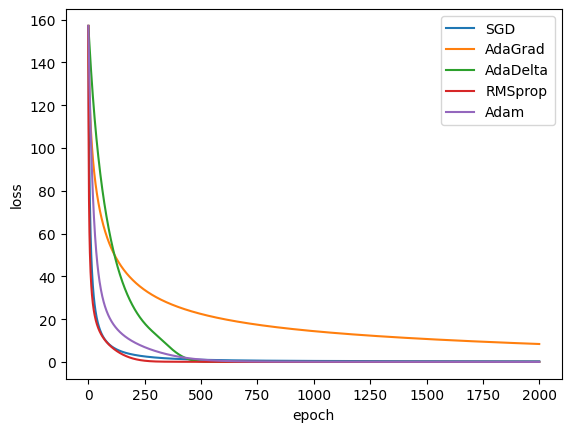

In [14]:
plot_data(losses, label='loss')

We calculate the optimizer path and elevation.

In [15]:
def calc_path(optimizers, params, loss, xyz):
    """
    Calculate the path taken of each optimizer in optimizers
    
    Input/s:
        optimizers : dictionary of optimizers
        params     : (dictionary) updated params of optimizer per epoch
        loss       : (dictionary) losses of optimizer per epoch
        xyz        : (x,y,z) ndarray parameters over (x,y) bounds
    """
    optims = optimizers.keys()
    _, _, z = xyz
    paths = np.array([loss[optim] - z.min() + 1.1 for optim in optims])
    
    for (i, name) in enumerate(params):
        zmax = paths[i][np.isfinite(paths[i])].max()
    
    zmax = z.max()
    paths[np.isfinite(paths)==False] = zmax
    paths = np.clip(paths, 0, zmax)
    return optims, paths

In [16]:
optims, paths = calc_path(optimizers, params, losses, xyz)

In [17]:
def plot_3doptim(fcn, params, xyz, paths, show_plot=True):
    """
    Plots contour of function, with optimizer path
    
    Input/s:
        fcn    : Function()
        params : (dictionary) updated params of optimizer per epoch
        xyz    : (x,y,z) ndarray parameters over (x,y) bounds
        paths  : ndarray path taken by optimizer
    """
    minima = np.array([fcn.minima]).reshape(-1, 1)
    x0 = np.array([fcn.x0]).T
    x, y, z = xyz
    
    fig = plt.figure(figsize=(8,5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)
    
    ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, alpha=.25, cmap=plt.cm.jet)
    ax.plot(*minima, fcn.fcn(minima).numpy(), 'r*', markersize=10)
    ax.plot(*x0, fcn.fcn(x0).numpy(), 'r+', markersize=10)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((fcn.xmin, fcn.xmax))
    ax.set_ylim((fcn.ymin, fcn.ymax))
    
    # Adding the optimizer
    ax = plt.gca()
    for (i, name) in enumerate(params):
        ax.scatter3D(*params[name].T, paths[i], label=name, s=1)
    plt.legend()
    plt.xlim(fcn.xmin, fcn.xmax)
    plt.ylim(fcn.ymin, fcn.ymax)
    
    ax.legend(loc='upper right')
    if show_plot:
        plt.show()
    return ax

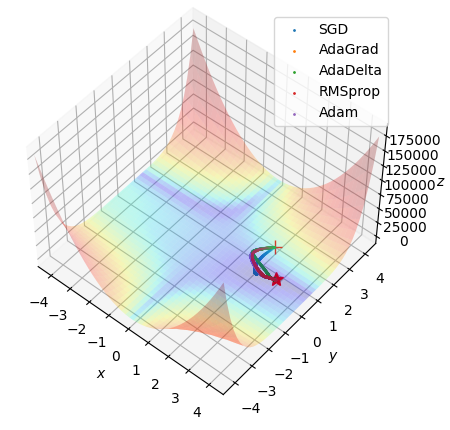

<Axes3DSubplot: xlabel='$x$', ylabel='$y$', zlabel='$z$'>

In [18]:
plot_3doptim(beales, params, xyz, paths)

## Animation

We animate the performance of our optimizer.

In [19]:
from matplotlib import animation
from itertools import zip_longest

class TrajectoryAnimation(animation.FuncAnimation):
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [20]:
paths = np.array([path.T for path in params.values()])
anim = TrajectoryAnimation(*paths[:,:,:2000:1], labels=optims, ax=contour2d)
contour2d.legend(loc='upper right')

In [21]:
from IPython.display import HTML
HTML(anim.to_html5_video())

### Six-Hump Camel Function

Let us experiment with a function containing multiple local minima.

$$
f(x,y) = (4-2.1x^2 + \frac{x^4}{3})x^2 + xy + (-4+4y^2)y^2
$$

Visualize function [here](https://www.sfu.ca/~ssurjano/camel6.html).

In [22]:
def six_humped(params):
    x, y = params
    x = Tensor(x)
    y = Tensor(y)
    return (4-2.1*x**2 + x**4/3)*x**2 + x*y + (-4+4*y**2)*y**2

In [23]:
# Six-humped parameters
x0 = [1.3, -1.5]
minima = [0.0898, -0.7126]
bounds = [[-3, 3], [-2, 2]]
lr = 1e-3
num_epochs = 2000
param_step = 0.2

sixhump = Function(fcn=six_humped, x0=x0, minima=minima, bounds=bounds, lr=lr, epoch=num_epochs)

/tmp/ipykernel_13145/4262824430.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  cm = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


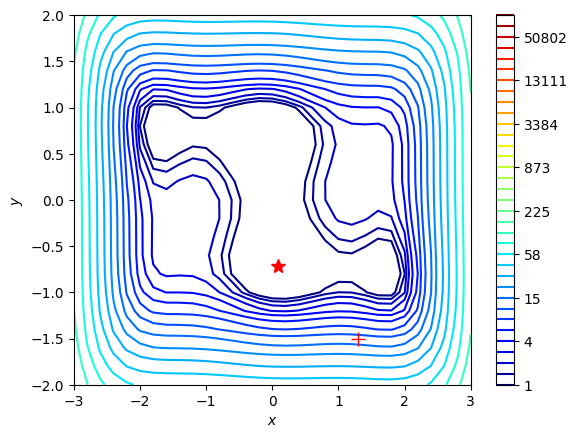

In [24]:
# Speedrunning through the steps
xyz = fcn_over_bounds(sixhump)                             # Calc xyz over bounds
contour2d = plot_2dcontour(sixhump, xyz, show_plot=False)  # Generate contour plot
params, losses, lrs = test_optim(sixhump, optimizers)      # Run over optimizers
optims, paths = calc_path(optimizers, params, losses, xyz) # Calc optim path

In [25]:
# Animation
paths = np.array([path.T for path in params.values()])
anim = TrajectoryAnimation(*paths[:,:,:2000:1], labels=optims, ax=contour2d)
contour2d.legend(loc='upper right')

HTML(anim.to_html5_video())

Experiment by trying other optimizers, adding noise, or incorporating a learning rate scheduler.